<a href="https://colab.research.google.com/github/llafcode/IntroDL_EX03_AutoLyrics/blob/master/EX03_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation



This code installs a time utility to measure run time of cells.

In [11]:
%%capture
!pip install ipython-autotime

%load_ext autotime

time: 3.51 s


The dataset was uploaded to [llafcode/IntroDL_EX03_AutoLyrics](https://github.com/llafcode/IntroDL_EX03_AutoLyrics), so we first need to clone the repository, with the data. To make things easier, we also define:

*   `repo_path` - the repository path (this should be cross platrform since we use `os` module)
*   `train_path` - the train dataset path
*   `test_path` - the test dataset path



In [12]:
%%capture
import os

# Clone the entire repo.
!git clone -s git://github.com/llafcode/IntroDL_EX03_AutoLyrics.git AutoLyrics
repo_path = os.path.join(os.getcwd(), 'AutoLyrics')
melody_path = os.path.join(repo_path, 'data', 'midi_files')
train_data = os.path.join(repo_path, 'data', 'lyrics_train_set.csv')
test_data = os.path.join(repo_path, 'data', 'lyrics_test_set.csv')

time: 2.44 s


Next, we install TensorFlow 2.0 and import it

In [13]:
%%capture
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install -q tensorflow-gpu==2.0.0-alpha0
!pip install -q tf-nightly-gpu-2.0-preview

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

# For potential eager executions
# tf.enable_eager_execution()

time: 3.57 s


For reproducible results, we init numpy and tensorflow random seed with same values

In [14]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
np.random.seed(2)
tf.random.set_seed(2)

# Make sure we are set to GPU (under Runtime->Change runtime type)
print('Running on GPU' if tf.test.is_gpu_available() else 'Please change runtime type to GPU on Google Colab under Runtime')

Running on GPU
time: 14.5 ms


Import pretty midi

In [15]:
import pretty_midi

# For plotting
import mir_eval.display
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

# For putting audio in the notebook
import IPython.display

import seaborn as sns
sns.set()
# sns.set(rc={'figure.figsize':(15,15)})
# sns.set_palette('Paired', 12)

time: 8.58 ms


The documentation of Pretty_midi is availabel [here](https://craffel.github.io/pretty-midi/), and a jupyter notebook tutorial is available [here](https://nbviewer.jupyter.org/github/craffel/pretty-midi/blob/master/Tutorial.ipynb).

In [16]:
# Load a single mid file
pm = pretty_midi.PrettyMIDI(os.path.join(melody_path, '1910_Fruitgum_Company_-_Simon_Says.mid'))

time: 215 ms


A great way to visualize MIDI data is via a piano roll, which is a time-frequency matrix where each row is a different MIDI pitch and each column is a different slice in time. pretty_midi can produce piano roll matrices for each indivual instrument (via Instrument.get_piano_roll) or the entire PrettyMIDI object (summed across instruments, via PrettyMIDI.get_piano_roll). The spacing in time between subsequent columns of the matrix is determined by the fs parameter.

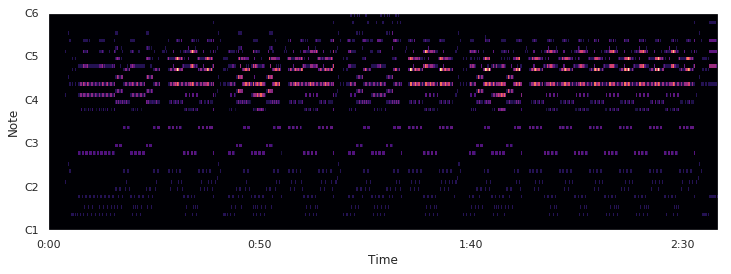

time: 1.66 s


In [17]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
  # Use librosa's specshow function for displaying the piano roll
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                           hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                           fmin=pretty_midi.note_number_to_hz(start_pitch))
  
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [18]:
# The instruments list
print(pm.instruments)

[Instrument(program=18, is_drum=False, name="Organ"), Instrument(program=34, is_drum=False, name="Bass"), Instrument(program=48, is_drum=False, name="Strings"), Instrument(program=67, is_drum=False, name="Melody"), Instrument(program=25, is_drum=False, name="6 String"), Instrument(program=0, is_drum=False, name="12 String"), Instrument(program=0, is_drum=False, name="Chips"), Instrument(program=61, is_drum=False, name="Brass"), Instrument(program=53, is_drum=False, name="Syn Vox"), Instrument(program=0, is_drum=True, name="Kick"), Instrument(program=16, is_drum=False, name="Solo Organ")]
time: 1.3 ms


In [19]:
# Listen it!
# IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)
# Sounds like sine waves...

time: 2.52 s


In [20]:
# Let's look at what's in this MIDI file
print(f'There are {len(pm.time_signature_changes)} time signature changes')
print(f'There are {len(pm.instruments)} instruments')
print(f'Instrument 3 has {len(pm.instruments[2].notes)} notes')
print(f'Instrument 4 has {len(pm.instruments[3].pitch_bends)} pitch bends')
print(f'Instrument 5 has {len(pm.instruments[4].control_changes)} control changes')

There are 1 time signature changes
There are 11 instruments
Instrument 3 has 155 notes
Instrument 4 has 0 pitch bends
Instrument 5 has 4 control changes
time: 4.33 ms


## Dataset analysis

In the csv file, there are more than three columns. We are currently not sure what are the other columns, and for the initial experiment, we start with only the first three columns.

In [21]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize


train = pd.read_csv(train_data, usecols=[0,1,2], names=['artist', 'song', 'lyric'], header=None)
train_lyrics = train.lyric.values
# train_lyrics_words = np.zeros_like(train_lyrics)

# Create a words dictionary, to count the frequency of all distinct words
# Currently without any filtering
all_words = {}
for song in train_lyrics:
  lyric_words = song.split(' ')
  for word in lyric_words:
    if word not in all_words:
      all_words[word] = 1
    else:
      all_words[word] += 1

vocab = all_words.keys()
print('Total number of words (raw): ', len(vocab))
word_frequency = [all_words[word] for word in vocab]

Total number of words (raw):  9049
time: 126 ms


## A lyric generation approach using LSTM (without melodies)

The input should be a sequence of words (could be one, or n-gram) and the output should be the next word. Therefore during training, we need to specify a n-gram length (>=1) as input for each timestamp, and the next word as the output of this timstamp.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.utils import np_utils

time: 1.71 ms


In [255]:
df_train = pd.read_csv(train_data, usecols=[0,1,2], names=['author', 'song', 'lyrics'])
df_train.head()

author  ...                                             lyrics
0      elton john  ...  goodbye norma jean & though i never knew you a...
1  gerry rafferty  ...  winding your way down on baker street & lite i...
2  gerry rafferty  ...  you know i need your love & you've got that ho...
3     2 unlimited  ...  come on check it out ya'll & (come on come on!...
4     2 unlimited  ...  let the beat control your body & let the beat ...

[5 rows x 3 columns]

time: 32.7 ms


In [253]:
def remove_noise_char(lyrics):
  # Replace '' with " (later remove it)
  ret = lyrics.str.replace(r"''", '"')
  
  # Replace ` with '
  ret = ret.str.replace(r'`', "'")
  
  # Replace / with - (appears in 24/7)
  ret = ret.str.replace(r'/', '-')

  # Replace three ? with one
  ret = ret.str.replace('\?\?\?', '?')

  # Replace all brackets, :;#", and weird chars
  ret = ret.str.replace(r'[\[\]()\{\}:;#\*"ã¤¼©¦­]', '')
  
  # Remove certain words
  for word in ['chorus', '\-\-\-', '\-\-']:
    ret = ret.str.replace(word, '')
    
  # Replace these words with space
  for word in ['\.\.\.\.\.', '\.\.\.\.', '\.\.\.', '\.\.', " '"]:
    ret = ret.str.replace(word, ' ')
    
  # Remove duplicate spaces
  ret = ret.apply(lambda s: ' '.join(s.split()))
  return ret

time: 5.47 ms


In [132]:
%%capture
# !python -m nltk.downloader all

time: 458 µs


In [131]:
# import nltk
# nltk.download('punkt', quiet=True)
# from nltk import word_tokenize

time: 33 ms
